<a href="https://colab.research.google.com/github/cching3/project/blob/main/new_video_text_transformer_10epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ================================================================
# 0. Imports & config
# ================================================================
import os
from pathlib import Path
import matplotlib.pyplot as plt

import cv2
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
)

from torchvision import models, transforms
from PIL import Image

from transformers import RobertaModel, RobertaTokenizerFast

# Reproducibility
SEED = 42
import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# ================================================================
# 1. Paths & basic hyperparams
# ================================================================
# TODO: change these to match your env (these mirror your old notebooks)
DATASET_ROOT = Path("/content/drive/MyDrive/Deep Learning Project/Real-life_Deception_Detection_2016")
CSV_ROOT     = Path("/content/drive/MyDrive/Deep Learning Project/Real-life_Deception_Detection_2016/split_data")

CLIPS_DIR        = DATASET_ROOT / "Clips"
TRANSCRIPTS_ROOT = DATASET_ROOT / "Transcription"

train_df = pd.read_csv(CSV_ROOT / "train.csv")
test_df  = pd.read_csv(CSV_ROOT / "test.csv")

video_col = train_df.columns[0]
label_col = train_df.columns[1]

print("Train size:", len(train_df))
print("Test size:", len(test_df))

# Video hyperparams
IMG_SIZE       = 224
MAX_SEQ_LENGTH = 20      # max frames per video
BATCH_SIZE     = 4
EPOCHS         = 10       # you can bump up later
LR             = 2e-5

# Transformer (video) hyperparams
EMBED_DIM  = 256
NUM_HEADS  = 4
FF_DIM     = 512
NUM_LAYERS = 2
DROPOUT    = 0.3

# Text hyperparams
TEXT_MAX_LEN = 256
ROBERTA_NAME = "roberta-base"

NUM_CLASSES = 2


Train size: 96
Test size: 25


In [ ]:

# ================================================================
# 2. Label + transcript helpers
# ================================================================
def get_transcript_path_and_label(video_name, raw_label):
    """
    video_name: e.g. 'Deceptive/TrialXYZ.mp4' or just 'TrialXYZ.mp4'
    raw_label: may be 'Truthful'/'Deceptive' or 1/0
    Returns:
        transcript_path (Path)
        numeric_label (int: 0=Deceptive, 1=Truthful)
    """
    base = os.path.splitext(os.path.basename(video_name))[0]
    txt_name = base + ".txt"

    lbl_str = str(raw_label).lower()
    if lbl_str in ["truthful", "truth", "1", "true"]:
        subdir = "Truthful"
        numeric_label = 1
    else:
        subdir = "Deceptive"
        numeric_label = 0

    transcript_path = TRANSCRIPTS_ROOT / subdir / txt_name
    return transcript_path, numeric_label


def build_texts_and_labels_for_df(df):
    texts   = []
    labels  = []
    missing = 0

    for _, row in df.iterrows():
        video_name = row[video_col]
        raw_label  = row[label_col]

        transcript_path, numeric_label = get_transcript_path_and_label(video_name, raw_label)

        if transcript_path.exists():
            with open(transcript_path, "r", encoding="utf-8") as f:
                text = f.read().strip()
            texts.append(text)
            labels.append(numeric_label)
        else:
            missing += 1

    print(f"Loaded {len(texts)} transcripts, missing {missing}")
    return np.array(texts, dtype=object), np.array(labels, dtype=np.int64)


print("Building texts for TRAIN...")
train_texts, train_labels_y = build_texts_and_labels_for_df(train_df)

print("Building texts for TEST...")
test_texts, test_labels_y = build_texts_and_labels_for_df(test_df)

Building texts for TRAIN...
Loaded 96 transcripts, missing 0
Building texts for TEST...
Loaded 25 transcripts, missing 0


In [ ]:
# ================================================================
# 3. Video feature extractor (ResNet18 backbone)
# ================================================================
frame_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225],
    ),
])

resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet_feature_extractor = nn.Sequential(*list(resnet.children())[:-2])  # up to last conv
for p in resnet_feature_extractor.parameters():
    p.requires_grad = False
resnet_feature_extractor.to(device)
resnet_feature_extractor.eval()

FEAT_DIM = 512  # conv5 channels

@torch.no_grad()
def extract_frame_features(frames):
    """
    frames: list of PIL images
    returns: (T, FEAT_DIM) frame features
    """
    if len(frames) == 0:
        return torch.zeros((0, FEAT_DIM), device=device)

    tensors = [frame_transform(f) for f in frames]
    batch = torch.stack(tensors).to(device)  # (T,3,H,W)

    feats = resnet_feature_extractor(batch)          # (T, 512, H', W')
    feats = F.adaptive_avg_pool2d(feats, (1, 1))     # (T,512,1,1)
    feats = feats.view(feats.size(0), FEAT_DIM)      # (T,512)
    return feats


def load_video_frames_uniform(path, max_frames=MAX_SEQ_LENGTH):
    """
    Load up to max_frames frames uniformly from the video.
    Returns list of PIL Images.
    """
    cap = cv2.VideoCapture(str(path))
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        cap.release()
        return frames

    # choose indices uniformly
    idxs = np.linspace(0, total_frames - 1, num=min(max_frames, total_frames), dtype=int)

    frame_id = 0
    idxs_set = set(int(i) for i in idxs)

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_id in idxs_set:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(Image.fromarray(frame_rgb))
        frame_id += 1

    cap.release()
    return frames


def prepare_video_features_for_df(df):
    """
    Precompute ResNet features for each video in df.
    Returns:
        features: (N, MAX_SEQ_LENGTH, FEAT_DIM)
        masks:    (N, MAX_SEQ_LENGTH) bool, True where valid frame
        labels:   (N,) numeric labels 0/1
    """
    N = len(df)
    features = np.zeros((N, MAX_SEQ_LENGTH, FEAT_DIM), dtype=np.float32)
    masks    = np.zeros((N, MAX_SEQ_LENGTH), dtype=bool)
    labels   = np.zeros((N,), dtype=np.int64)

    for idx, (_, row) in enumerate(df.iterrows()):
        video_name = row[video_col]
        raw_label  = row[label_col]

        # label to numeric
        _, numeric_label = get_transcript_path_and_label(video_name, raw_label)
        labels[idx] = numeric_label

        video_path = CLIPS_DIR / video_name
        frames = load_video_frames_uniform(video_path, max_frames=MAX_SEQ_LENGTH)
        with torch.no_grad():
            feats = extract_frame_features(frames)  # (T, FEAT_DIM)
        T = min(MAX_SEQ_LENGTH, feats.shape[0])
        if T > 0:
            features[idx, :T, :] = feats[:T].cpu().numpy()
            masks[idx, :T] = True

        if (idx + 1) % 5 == 0 or idx == N - 1:
            print(f"Processed {idx+1}/{N} videos", end="\r")

    print("\nDone precomputing video features.")
    return features, masks, labels


print("Precomputing VIDEO features for TRAIN...")
train_features, train_masks, train_labels_video = prepare_video_features_for_df(train_df)

print("Precomputing VIDEO features for TEST...")
test_features, test_masks, test_labels_video = prepare_video_features_for_df(test_df)

# Sanity check labels are consistent between text + video paths
assert np.all(train_labels_y == train_labels_video), "Train label mismatch!"
assert np.all(test_labels_y  == test_labels_video),  "Test label mismatch!"

labels_train = train_labels_y
labels_test  = test_labels_y

print("Train features shape:", train_features.shape)
print("Train masks   shape:", train_masks.shape)

Precomputing VIDEO features for TRAIN...
Processed 96/96 videos
Done precomputing video features.
Precomputing VIDEO features for TEST...
Processed 25/25 videos
Done precomputing video features.
Train features shape: (96, 20, 512)
Train masks   shape: (96, 20)



========== Fold 1 / 5 ==========


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 | Epoch 01 | train_loss=0.7435, train_acc=0.461 | val_loss=0.6932, val_acc=0.500, val_f1=0.000
Fold 1 | Epoch 02 | train_loss=0.6913, train_acc=0.566 | val_loss=0.6676, val_acc=0.650, val_f1=0.696
Fold 1 | Epoch 03 | train_loss=0.6488, train_acc=0.645 | val_loss=0.6446, val_acc=0.600, val_f1=0.600
Fold 1 | Epoch 04 | train_loss=0.5351, train_acc=0.789 | val_loss=0.7906, val_acc=0.500, val_f1=0.667
Fold 1 | Epoch 05 | train_loss=0.3522, train_acc=0.868 | val_loss=0.5776, val_acc=0.750, val_f1=0.783
Fold 1 | Epoch 06 | train_loss=0.2290, train_acc=0.947 | val_loss=0.8091, val_acc=0.600, val_f1=0.692
Fold 1 | Epoch 07 | train_loss=0.0515, train_acc=1.000 | val_loss=0.8784, val_acc=0.650, val_f1=0.588
Fold 1 | Epoch 08 | train_loss=0.0298, train_acc=1.000 | val_loss=0.7901, val_acc=0.750, val_f1=0.762
Fold 1 | Epoch 09 | train_loss=0.0322, train_acc=0.987 | val_loss=1.7461, val_acc=0.500, val_f1=0.286
Fold 1 | Epoch 10 | train_loss=0.3942, train_acc=0.868 | val_loss=0.8581, val_acc=

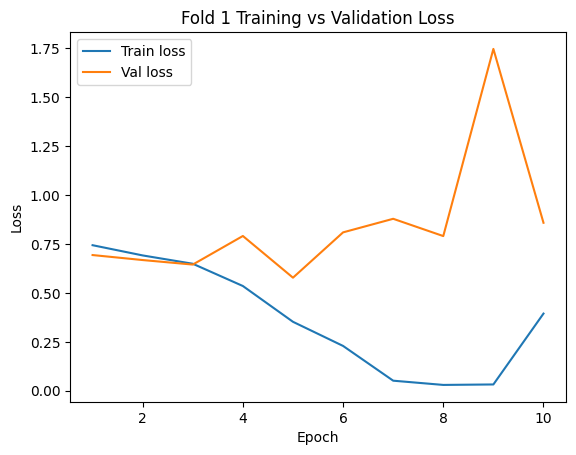


========== Fold 2 / 5 ==========


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 2 | Epoch 01 | train_loss=0.6861, train_acc=0.545 | val_loss=0.6637, val_acc=0.632, val_f1=0.588
Fold 2 | Epoch 02 | train_loss=0.6489, train_acc=0.662 | val_loss=0.6479, val_acc=0.789, val_f1=0.818
Fold 2 | Epoch 03 | train_loss=0.6574, train_acc=0.623 | val_loss=0.6295, val_acc=0.789, val_f1=0.800


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 | Epoch 04 | train_loss=0.5851, train_acc=0.701 | val_loss=0.7280, val_acc=0.474, val_f1=0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2 | Epoch 05 | train_loss=0.3917, train_acc=0.922 | val_loss=1.0058, val_acc=0.474, val_f1=0.000
Fold 2 | Epoch 06 | train_loss=0.5354, train_acc=0.766 | val_loss=0.6806, val_acc=0.474, val_f1=0.167
Fold 2 | Epoch 07 | train_loss=0.2080, train_acc=0.974 | val_loss=0.6617, val_acc=0.684, val_f1=0.727
Fold 2 | Epoch 08 | train_loss=0.1057, train_acc=0.987 | val_loss=0.9303, val_acc=0.632, val_f1=0.667
Fold 2 | Epoch 09 | train_loss=0.1039, train_acc=0.974 | val_loss=0.9052, val_acc=0.684, val_f1=0.727
Fold 2 | Epoch 10 | train_loss=0.2236, train_acc=0.909 | val_loss=0.9460, val_acc=0.579, val_f1=0.556
Best Fold 2 val metrics: {'loss': 0.6478914367525201, 'acc': 0.7894736842105263, 'precision': 0.75, 'recall': 0.9, 'f1': 0.8181818181818182, 'auc': np.float64(0.7888888888888889)}


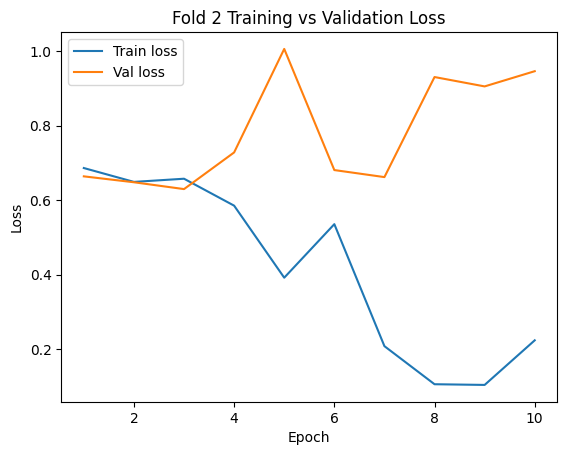


========== Fold 3 / 5 ==========


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 3 | Epoch 01 | train_loss=0.7174, train_acc=0.494 | val_loss=0.6667, val_acc=0.526, val_f1=0.690
Fold 3 | Epoch 02 | train_loss=0.6590, train_acc=0.636 | val_loss=0.6584, val_acc=0.474, val_f1=0.375
Fold 3 | Epoch 03 | train_loss=0.6643, train_acc=0.610 | val_loss=0.6440, val_acc=0.842, val_f1=0.870
Fold 3 | Epoch 04 | train_loss=0.5997, train_acc=0.714 | val_loss=0.6042, val_acc=0.632, val_f1=0.720
Fold 3 | Epoch 05 | train_loss=0.5159, train_acc=0.779 | val_loss=0.5087, val_acc=0.737, val_f1=0.800
Fold 3 | Epoch 06 | train_loss=0.3407, train_acc=0.922 | val_loss=0.3092, val_acc=0.895, val_f1=0.889
Fold 3 | Epoch 07 | train_loss=0.3436, train_acc=0.844 | val_loss=0.4255, val_acc=0.789, val_f1=0.800
Fold 3 | Epoch 08 | train_loss=0.1284, train_acc=0.987 | val_loss=0.5538, val_acc=0.737, val_f1=0.783
Fold 3 | Epoch 09 | train_loss=0.0541, train_acc=1.000 | val_loss=1.0619, val_acc=0.632, val_f1=0.720
Fold 3 | Epoch 10 | train_loss=0.0270, train_acc=1.000 | val_loss=1.4842, val_acc=

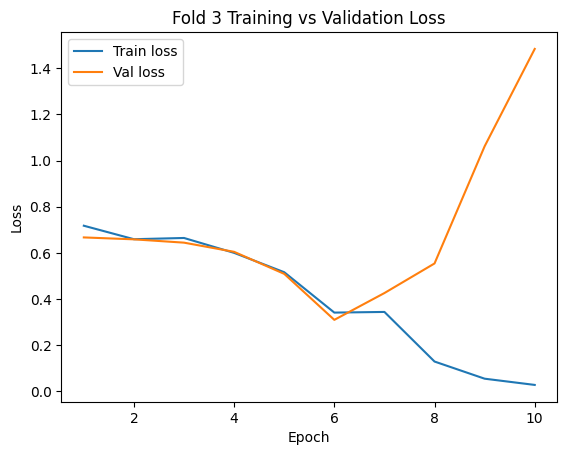


========== Fold 4 / 5 ==========


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 4 | Epoch 01 | train_loss=0.7167, train_acc=0.442 | val_loss=0.6789, val_acc=0.526, val_f1=0.667
Fold 4 | Epoch 02 | train_loss=0.6605, train_acc=0.610 | val_loss=0.6566, val_acc=0.737, val_f1=0.706
Fold 4 | Epoch 03 | train_loss=0.6576, train_acc=0.636 | val_loss=0.6356, val_acc=0.684, val_f1=0.750
Fold 4 | Epoch 04 | train_loss=0.5788, train_acc=0.727 | val_loss=0.6151, val_acc=0.632, val_f1=0.720
Fold 4 | Epoch 05 | train_loss=0.4223, train_acc=0.896 | val_loss=0.5663, val_acc=0.632, val_f1=0.588
Fold 4 | Epoch 06 | train_loss=0.2285, train_acc=0.935 | val_loss=0.8800, val_acc=0.632, val_f1=0.364
Fold 4 | Epoch 07 | train_loss=0.0801, train_acc=1.000 | val_loss=0.9062, val_acc=0.632, val_f1=0.588
Fold 4 | Epoch 08 | train_loss=0.0345, train_acc=1.000 | val_loss=0.8899, val_acc=0.789, val_f1=0.714
Fold 4 | Epoch 09 | train_loss=0.0174, train_acc=1.000 | val_loss=0.9824, val_acc=0.737, val_f1=0.667
Fold 4 | Epoch 10 | train_loss=0.0131, train_acc=1.000 | val_loss=1.0526, val_acc=

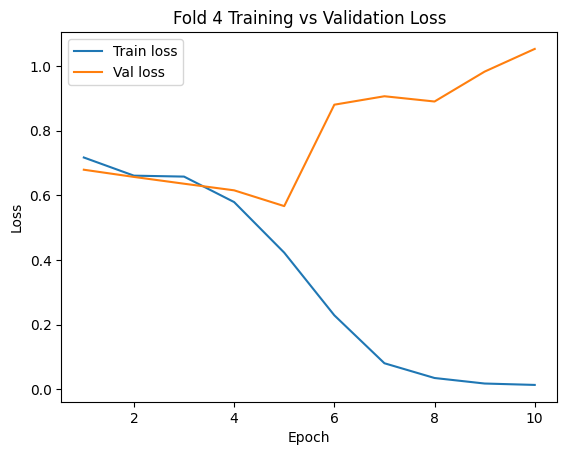


========== Fold 5 / 5 ==========


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 5 | Epoch 01 | train_loss=0.7053, train_acc=0.494 | val_loss=0.6929, val_acc=0.632, val_f1=0.696
Fold 5 | Epoch 02 | train_loss=0.6691, train_acc=0.597 | val_loss=0.6823, val_acc=0.526, val_f1=0.471
Fold 5 | Epoch 03 | train_loss=0.6450, train_acc=0.688 | val_loss=0.6691, val_acc=0.526, val_f1=0.308
Fold 5 | Epoch 04 | train_loss=0.5949, train_acc=0.805 | val_loss=0.6577, val_acc=0.421, val_f1=0.353
Fold 5 | Epoch 05 | train_loss=0.4492, train_acc=0.935 | val_loss=0.7126, val_acc=0.632, val_f1=0.364
Fold 5 | Epoch 06 | train_loss=0.3035, train_acc=0.896 | val_loss=1.0410, val_acc=0.526, val_f1=0.640
Fold 5 | Epoch 07 | train_loss=0.1420, train_acc=0.961 | val_loss=1.1478, val_acc=0.474, val_f1=0.500
Fold 5 | Epoch 08 | train_loss=0.0445, train_acc=1.000 | val_loss=1.7265, val_acc=0.421, val_f1=0.476
Fold 5 | Epoch 09 | train_loss=0.0259, train_acc=1.000 | val_loss=1.9471, val_acc=0.421, val_f1=0.476
Fold 5 | Epoch 10 | train_loss=0.0159, train_acc=1.000 | val_loss=2.1173, val_acc=

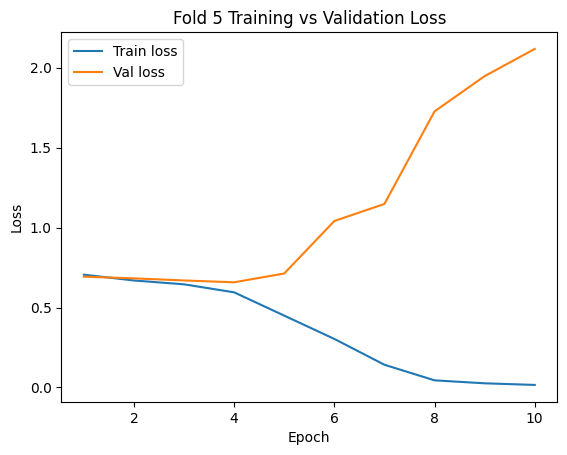


========== CV SUMMARY ==========
Fold 1: acc=0.750, f1=0.783, auc=0.750
Fold 2: acc=0.789, f1=0.818, auc=0.789
Fold 3: acc=0.895, f1=0.889, auc=1.000
Fold 4: acc=0.789, f1=0.714, auc=0.844
Fold 5: acc=0.632, f1=0.696, auc=0.533
Mean CV acc = 0.771

========== Final training on FULL train set ==========


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[FULL train] Epoch 01 | loss=0.6749, acc=0.562
[FULL train] Epoch 02 | loss=0.6654, acc=0.615
[FULL train] Epoch 03 | loss=0.5887, acc=0.781
[FULL train] Epoch 04 | loss=0.5046, acc=0.823
[FULL train] Epoch 05 | loss=0.3536, acc=0.875
[FULL train] Epoch 06 | loss=0.1460, acc=0.969
[FULL train] Epoch 07 | loss=0.1778, acc=0.938
[FULL train] Epoch 08 | loss=0.0505, acc=0.990
[FULL train] Epoch 09 | loss=0.0191, acc=1.000
[FULL train] Epoch 10 | loss=0.0127, acc=1.000


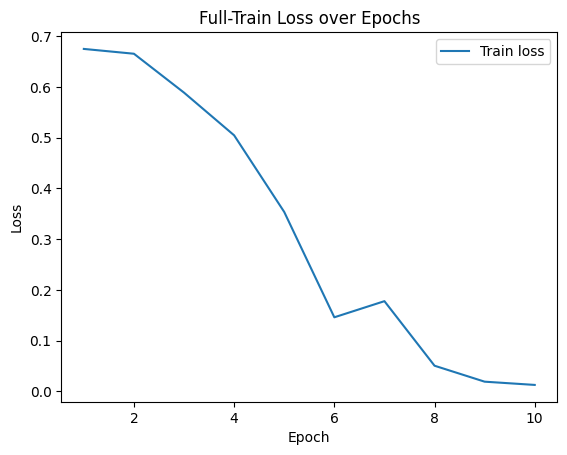


========== Evaluate on HELD-OUT TEST set ==========
Test metrics: {'loss': 0.8463527439534664, 'acc': 0.76, 'precision': 0.7142857142857143, 'recall': 0.8333333333333334, 'f1': 0.7692307692307693, 'auc': np.float64(0.8397435897435896)}


In [ ]:
# ================================================================
# 4. Dataset for multimodal data
# ================================================================
tokenizer = RobertaTokenizerFast.from_pretrained(ROBERTA_NAME)

class MultimodalDeceptionDataset(Dataset):
    def __init__(self, features, masks, texts, labels, tokenizer, text_max_len):
        """
        features: (N, T, FEAT_DIM)
        masks:    (N, T) bool
        texts:    array/list of strings length N
        labels:   (N,) int64
        """
        self.features   = features
        self.masks      = masks
        self.texts      = texts
        self.labels     = labels
        self.tokenizer  = tokenizer
        self.text_max_len = text_max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        vid_feat = torch.tensor(self.features[idx], dtype=torch.float32)   # (T, FEAT_DIM)
        vid_mask = torch.tensor(self.masks[idx],   dtype=torch.bool)      # (T,)

        text = str(self.texts[idx])
        enc  = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.text_max_len,
            return_tensors="pt",
        )
        input_ids      = enc["input_ids"].squeeze(0)        # (L,)
        attention_mask = enc["attention_mask"].squeeze(0)   # (L,)

        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return {
            "video_feats": vid_feat,
            "video_mask":  vid_mask,
            "input_ids":   input_ids,
            "attention_mask": attention_mask,
            "labels":      label,
        }


# ================================================================
# 5. Video Transformer encoder
# ================================================================
class VideoTransformer(nn.Module):
    def __init__(
        self,
        feat_dim,
        max_seq_len,
        embed_dim=256,
        num_heads=4,
        ff_dim=512,
        num_layers=2,
        dropout=0.3,
    ):
        super().__init__()
        self.max_seq_len = max_seq_len

        self.input_proj = nn.Linear(feat_dim, embed_dim)
        self.pos_embed  = nn.Parameter(torch.zeros(1, max_seq_len, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask_valid):
        """
        x: (B, T, feat_dim)
        mask_valid: (B, T) bool, True where there is a real frame
        """
        B, T, _ = x.shape

        x = self.input_proj(x)                         # (B,T,E)
        x = x + self.pos_embed[:, :T, :]              # (1,T,E) broadcast

        # Transformer uses src_key_padding_mask with True = PAD
        src_key_padding_mask = ~mask_valid            # (B,T)

        out = self.encoder(x, src_key_padding_mask=src_key_padding_mask)  # (B,T,E)

        # Masked mean pooling over valid frames
        mask_f = mask_valid.unsqueeze(-1).float()     # (B,T,1)
        summed = (out * mask_f).sum(dim=1)            # (B,E)
        denom = mask_f.sum(dim=1).clamp(min=1.0)      # (B,1)
        pooled = summed / denom                       # (B,E)
        pooled = self.dropout(pooled)
        return pooled                                 # (B,E)


# ================================================================
# 6. Combined multimodal classifier
# ================================================================
class MultiModalClassifier(nn.Module):
    def __init__(
        self,
        feat_dim,
        max_seq_len,
        num_classes=2,
        embed_dim=EMBED_DIM,
        num_heads=NUM_HEADS,
        ff_dim=FF_DIM,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT,
        text_model_name=ROBERTA_NAME,
        freeze_text_encoder=False,
    ):
        super().__init__()
        # Video encoder
        self.video_encoder = VideoTransformer(
            feat_dim=feat_dim,
            max_seq_len=max_seq_len,
            embed_dim=embed_dim,
            num_heads=num_heads,
            ff_dim=ff_dim,
            num_layers=num_layers,
            dropout=dropout,
        )

        # Text encoder (RoBERTa)
        self.text_encoder = RobertaModel.from_pretrained(text_model_name)
        text_hidden = self.text_encoder.config.hidden_size

        if freeze_text_encoder:
            for p in self.text_encoder.parameters():
                p.requires_grad = False

        # Project text features into same space as video
        self.text_proj = nn.Linear(text_hidden, embed_dim)

        # Fusion + classifier
        fusion_in_dim = embed_dim * 2
        self.fusion = nn.Sequential(
            nn.Linear(fusion_in_dim, fusion_in_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_in_dim, num_classes),
        )

    def forward(self, video_feats, video_mask, input_ids, attention_mask, labels=None):
        """
        video_feats: (B,T,FEAT_DIM)
        video_mask:  (B,T) bool
        input_ids:   (B,L)
        attention_mask: (B,L)
        labels: (B,) optional
        """
        # Video representation
        vid_repr = self.video_encoder(video_feats, video_mask)    # (B,E)

        # Text representation (CLS token)
        text_out = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        cls_repr = text_out.last_hidden_state[:, 0, :]           # (B, H_text)
        text_repr = self.text_proj(cls_repr)                     # (B,E)

        # Fuse
        fused = torch.cat([vid_repr, text_repr], dim=1)          # (B,2E)
        logits = self.fusion(fused)                              # (B,num_classes)

        loss = None
        if labels is not None:
            loss = F.cross_entropy(logits, labels)

        return logits, loss


# ================================================================
# 7. Training / evaluation helpers
# ================================================================
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0

    for batch in dataloader:
        video_feats    = batch["video_feats"].to(device)          # (B,T,FEAT_DIM)
        video_mask     = batch["video_mask"].to(device)           # (B,T)
        input_ids      = batch["input_ids"].to(device)            # (B,L)
        attention_mask = batch["attention_mask"].to(device)       # (B,L)
        labels         = batch["labels"].to(device)               # (B,)

        optimizer.zero_grad()
        logits, loss = model(video_feats, video_mask, input_ids, attention_mask, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_examples += labels.size(0)

    avg_loss = total_loss / total_examples
    avg_acc  = total_correct / total_examples
    return avg_loss, avg_acc


@torch.no_grad()
def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    y_true = []
    y_pred = []
    y_prob1 = []   # probability of class 1 (Truthful)

    total_examples = 0

    for batch in dataloader:
        video_feats    = batch["video_feats"].to(device)
        video_mask     = batch["video_mask"].to(device)
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        logits, loss = model(video_feats, video_mask, input_ids, attention_mask, labels)

        probs = F.softmax(logits, dim=1)[:, 1]  # P(class=1)
        preds = logits.argmax(dim=1)

        total_loss += loss.item() * labels.size(0)
        total_examples += labels.size(0)

        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())
        y_prob1.extend(probs.cpu().numpy().tolist())

    avg_loss = total_loss / total_examples
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", pos_label=1
    )

    try:
        auc = roc_auc_score(y_true, y_prob1)
    except ValueError:
        auc = float("nan")

    metrics = {
        "loss": avg_loss,
        "acc": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc,
    }
    return metrics


# ================================================================
# 8. 5-fold cross validation on TRAIN ONLY (with loss curves)
# ================================================================
N = len(labels_train)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

fold_results = []

for fold_idx, (tr_idx, val_idx) in enumerate(skf.split(np.arange(N), labels_train), start=1):
    print(f"\n========== Fold {fold_idx} / 5 ==========")

    X_train_feat = train_features[tr_idx]
    X_train_mask = train_masks[tr_idx]
    X_train_txt  = train_texts[tr_idx]
    y_train      = labels_train[tr_idx]

    X_val_feat   = train_features[val_idx]
    X_val_mask   = train_masks[val_idx]
    X_val_txt    = train_texts[val_idx]
    y_val        = labels_train[val_idx]

    train_dataset = MultimodalDeceptionDataset(
        X_train_feat, X_train_mask, X_train_txt, y_train,
        tokenizer=tokenizer,
        text_max_len=TEXT_MAX_LEN,
    )
    val_dataset = MultimodalDeceptionDataset(
        X_val_feat, X_val_mask, X_val_txt, y_val,
        tokenizer=tokenizer,
        text_max_len=TEXT_MAX_LEN,
    )

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)

    model = MultiModalClassifier(
        feat_dim=FEAT_DIM,
        max_seq_len=MAX_SEQ_LENGTH,
        num_classes=NUM_CLASSES,
        freeze_text_encoder=False,
    ).to(device)

    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=LR,
    )

    best_val_acc = 0.0
    best_val_metrics = None
    best_state_dict = None

    # history for plotting this fold
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, EPOCHS+1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device)
        val_metrics = evaluate_model(model, val_loader, device)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_metrics["loss"])

        print(
            f"Fold {fold_idx} | Epoch {epoch:02d} "
            f"| train_loss={train_loss:.4f}, train_acc={train_acc:.3f} "
            f"| val_loss={val_metrics['loss']:.4f}, "
            f"val_acc={val_metrics['acc']:.3f}, val_f1={val_metrics['f1']:.3f}"
        )

        if val_metrics["acc"] > best_val_acc:
            best_val_acc = val_metrics["acc"]
            best_val_metrics = val_metrics
            best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    fold_results.append({
        "fold": fold_idx,
        "best_val_acc": best_val_acc,
        "best_val_metrics": best_val_metrics,
        "state_dict": best_state_dict,
        "history": history,
    })
    print(f"Best Fold {fold_idx} val metrics:", best_val_metrics)

    # Plot training vs validation loss for this fold
    epochs_range = range(1, EPOCHS + 1)
    plt.figure()
    plt.plot(epochs_range, history["train_loss"], label="Train loss")
    plt.plot(epochs_range, history["val_loss"], label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Fold {fold_idx} Training vs Validation Loss")
    plt.legend()
    plt.show()

print("\n========== CV SUMMARY ==========")
for fr in fold_results:
    print(f"Fold {fr['fold']}: acc={fr['best_val_acc']:.3f}, "
          f"f1={fr['best_val_metrics']['f1']:.3f}, "
          f"auc={fr['best_val_metrics']['auc']:.3f}")

mean_acc = np.mean([fr["best_val_acc"] for fr in fold_results])
print(f"Mean CV acc = {mean_acc:.3f}")


# ================================================================
# 9. Final training on FULL train set + evaluation on HELD-OUT TEST
#    (with a simple train-loss curve)
# ================================================================
print("\n========== Final training on FULL train set ==========")

full_train_dataset = MultimodalDeceptionDataset(
    train_features, train_masks, train_texts, labels_train,
    tokenizer=tokenizer,
    text_max_len=TEXT_MAX_LEN,
)
full_train_loader = DataLoader(full_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = MultimodalDeceptionDataset(
    test_features, test_masks, test_texts, labels_test,
    tokenizer=tokenizer,
    text_max_len=TEXT_MAX_LEN,
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

final_model = MultiModalClassifier(
    feat_dim=FEAT_DIM,
    max_seq_len=MAX_SEQ_LENGTH,
    num_classes=NUM_CLASSES,
    freeze_text_encoder=False,
).to(device)

final_optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, final_model.parameters()),
    lr=LR,
)

full_history = {"train_loss": []}

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(final_model, full_train_loader, final_optimizer, device)
    full_history["train_loss"].append(tr_loss)
    print(f"[FULL train] Epoch {epoch:02d} | loss={tr_loss:.4f}, acc={tr_acc:.3f}")

# Plot final full-train loss curve
epochs_range = range(1, EPOCHS + 1)
plt.figure()
plt.plot(epochs_range, full_history["train_loss"], label="Train loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Full-Train Loss over Epochs")
plt.legend()
plt.show()

print("\n========== Evaluate on HELD-OUT TEST set ==========")
test_metrics = evaluate_model(final_model, test_loader, device)
print("Test metrics:", test_metrics)

In [ ]:
# Accuracy (5-fold CV) = 0.729 ± 0.058

Gathering predictions for calibration analysis...

========== Calibration Results ==========
Expected Calibration Error (ECE): 0.2423
  * Lower is better. 0.0 is perfect calibration.
  * < 0.05 is excellent; > 0.20 is poorly calibrated.


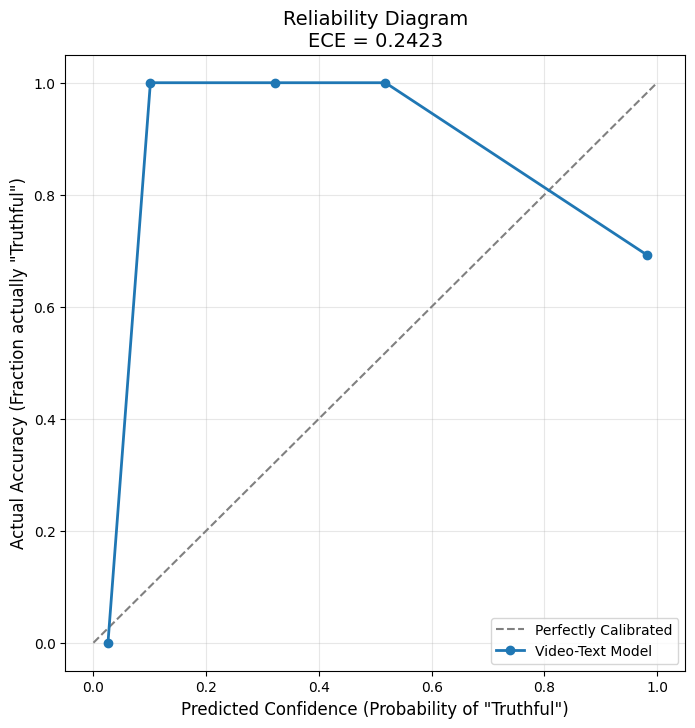

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from sklearn.calibration import calibration_curve

def analyze_calibration(model, dataloader, device, n_bins=10):
    """
    Computes ECE and plots a Reliability Diagram for a binary classifier.
    """
    model.eval()
    all_probs = []
    all_labels = []

    # 1. Gather all predictions and labels
    print("Gathering predictions for calibration analysis...")
    with torch.no_grad():
        for batch in dataloader:
            video_feats = batch["video_feats"].to(device)
            video_mask = batch["video_mask"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Get logits
            logits, _ = model(video_feats, video_mask, input_ids, attention_mask, labels)

            # Apply Softmax to get probabilities (confidence)
            probs = F.softmax(logits, dim=1)[:, 1]  # Probability of Class 1 (Truthful)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # 2. Calculate Reliability Diagram data using sklearn
    prob_true, prob_pred = calibration_curve(all_labels, all_probs, n_bins=n_bins, strategy='uniform')

    # 3. Calculate Expected Calibration Error (ECE) Manually
    # ECE = weighted average of |accuracy - confidence| for each bin
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Indices of samples in this bin
        in_bin = (all_probs > bin_lower) & (all_probs <= bin_upper)
        prop_in_bin = np.mean(in_bin)

        if prop_in_bin > 0:
            # Accuracy in this bin
            accuracy = np.mean(all_labels[in_bin])
            # Average confidence in this bin
            avg_confidence = np.mean(all_probs[in_bin])

            ece += np.abs(avg_confidence - accuracy) * prop_in_bin

    print(f"\n========== Calibration Results ==========")
    print(f"Expected Calibration Error (ECE): {ece:.4f}")
    print(f"  * Lower is better. 0.0 is perfect calibration.")
    print(f"  * < 0.05 is excellent; > 0.20 is poorly calibrated.")

    # 4. Plot Reliability Diagram
    plt.figure(figsize=(8, 8))

    # Plot perfect calibration line
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

    # Plot model's calibration curve
    plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Video-Text Model')

    # Visual Polish
    plt.title(f'Reliability Diagram\nECE = {ece:.4f}', fontsize=14)
    plt.xlabel('Predicted Confidence (Probability of "Truthful")', fontsize=12)
    plt.ylabel('Actual Accuracy (Fraction actually "Truthful")', fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

    # [Image of Reliability Diagram example]
    # Triggering conceptual tag for understanding
    plt.show()

# --- Run the Analysis ---
# Assumes 'final_model' and 'test_loader' are already defined from your notebook
analyze_calibration(final_model, test_loader, device)

Gathering predictions for histogram...


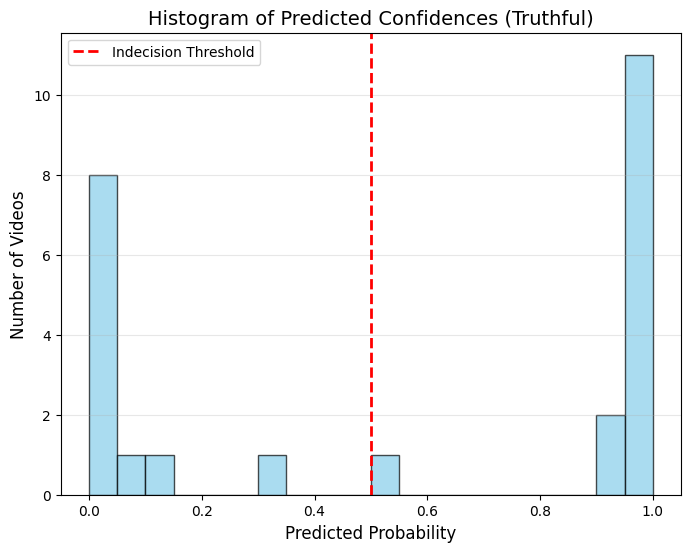

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# 1. Re-gather the probabilities from the model
# (We need to run this briefly to populate the list again)
final_model.eval()
all_probs = []

print("Gathering predictions for histogram...")
with torch.no_grad():
    for batch in test_loader:
        # Move data to the correct device
        video_feats = batch["video_feats"].to(device)
        video_mask = batch["video_mask"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        logits, _ = final_model(video_feats, video_mask, input_ids, attention_mask, labels)

        # Calculate probabilities for "Truthful" (Class 1)
        probs = F.softmax(logits, dim=1)[:, 1]
        all_probs.extend(probs.cpu().numpy())

# 2. Plot the Histogram
plt.figure(figsize=(8, 6))
plt.hist(all_probs, bins=20, range=(0, 1), edgecolor='black', alpha=0.7, color='skyblue')
plt.title("Histogram of Predicted Confidences (Truthful)", fontsize=14)
plt.xlabel("Predicted Probability", fontsize=12)
plt.ylabel("Number of Videos", fontsize=12)

# Add a red line at 0.5 (Indecision)
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label="Indecision Threshold")
plt.legend()
plt.grid(axis='y', alpha=0.3)



plt.show()